In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re, nltk
from collections import Counter
from nltk.corpus import stopwords
sns.set_style('darkgrid')

In [2]:
user_items = pd.read_parquet(r"C:\Users\roylo\OneDrive\Documentos\Data Science\Proyectos Individuales\Machine Learning Operations\Datasets\user_items.parquet")

user_items.head()

,user_id,items_count,item_id,item_name
0,76561197970982479,277,"[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38...","[Counter-Strike, Team Fortress Classic, Day of..."
1,js41637,888,"[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ...","[Counter-Strike, Counter-Strike: Condition Zer..."
2,evcentric,137,"[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3...","[Red Orchestra: Ostfront 41-45, Mare Nostrum, ..."
3,Riot-Punch,328,"[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300...","[Counter-Strike, Team Fortress Classic, Day of..."
4,doctr,541,"[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100...","[Day of Defeat: Source, Team Fortress Classic,..."


In [3]:
user_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   item_id      88310 non-null  object
 3   item_name    88310 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


## **`Duplicados`**

In [4]:
user_items[user_items['user_id'].duplicated()==True]

,user_id,items_count,item_id,item_name
865,bokkkbokkk,0,[],[]
1732,Nikiad,109,"[20, 50, 70, 130, 220, 340, 240, 280, 360, 320...","[Team Fortress Classic, Half-Life: Opposing Fo..."
2343,76561198079743094,48,"[240, 4000, 20, 50, 70, 130, 220, 280, 320, 34...","[Counter-Strike: Source, Garry's Mod, Team For..."
2344,ImSeriouss,50,"[4000, 10090, 12210, 24740, 17410, 620, 105600...","[Garry's Mod, Call of Duty: World at War, Gran..."
2394,76561198069124937,0,[],[]
...,...,...,...,...
48944,76561198035336388,5,"[22600, 620, 205790, 304930, 270570]","[Worms Reloaded, Portal 2, Dota 2 Test, Unturn..."
67355,76561198071790027,0,[],[]
69344,darkus0haos,122,"[240, 2100, 2130, 4000, 2600, 9450, 4580, 2331...","[Counter-Strike: Source, Dark Messiah of Might..."
73424,76561198080057659,39,"[50, 70, 130, 240, 280, 360, 4000, 220, 320, 3...","[Half-Life: Opposing Force, Half-Life, Half-Li..."


## **`Nulos`**

In [5]:
user_items.isna().value_counts().to_dict()

{(False, False, False, False): 88310}

## **`Análisis Univariable`**

In [6]:
user_items.columns

Index(['user_id', 'items_count', 'item_id', 'item_name'], dtype='object')

### **`User ID`**

In [7]:
int(user_items['user_id'].nunique()/user_items.shape[0] * 100)

99

### **`Conteo de Items`**

In [8]:
user_items[user_items['items_count'] < 0]

,user_id,items_count,item_id,item_name


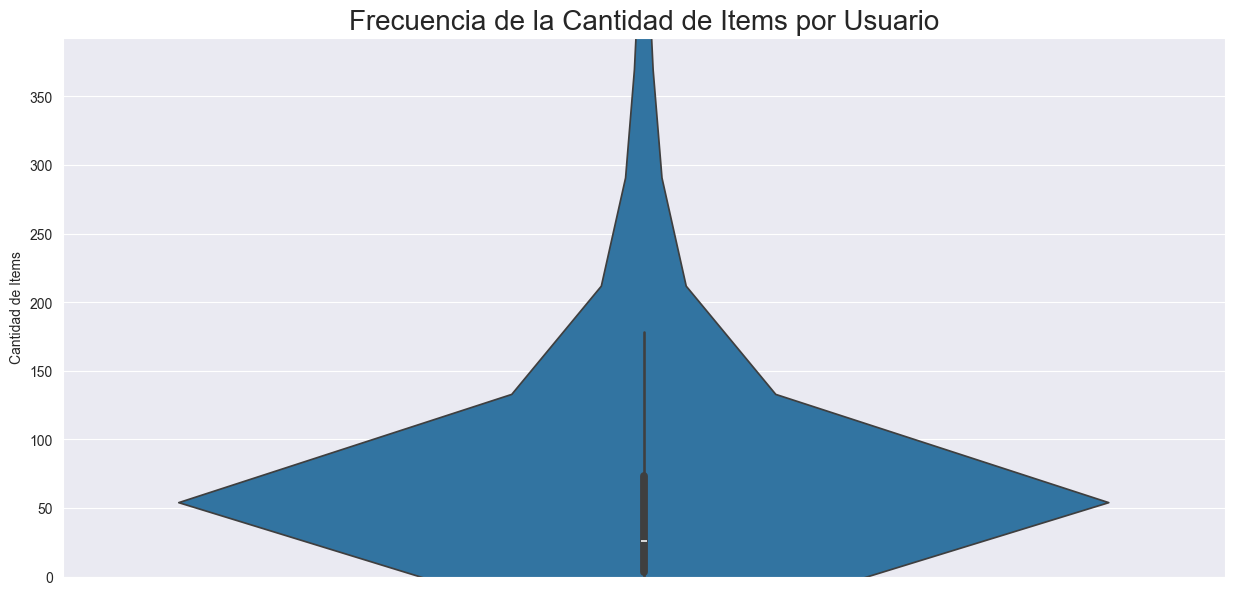

In [9]:
items_count = user_items[['user_id','items_count']]
items_count['user_id'].drop_duplicates()
items_count = items_count['items_count']

median = np.median(items_count.sort_values())

plt.figure(figsize=(15,7))

sns.violinplot(items_count)

plt.title("Frecuencia de la Cantidad de Items por Usuario", fontsize=20)
plt.ylabel("Cantidad de Items")
plt.ylim(0, median + (3*np.std(items_count)))
plt.show()

### **`Nombre del Item`**

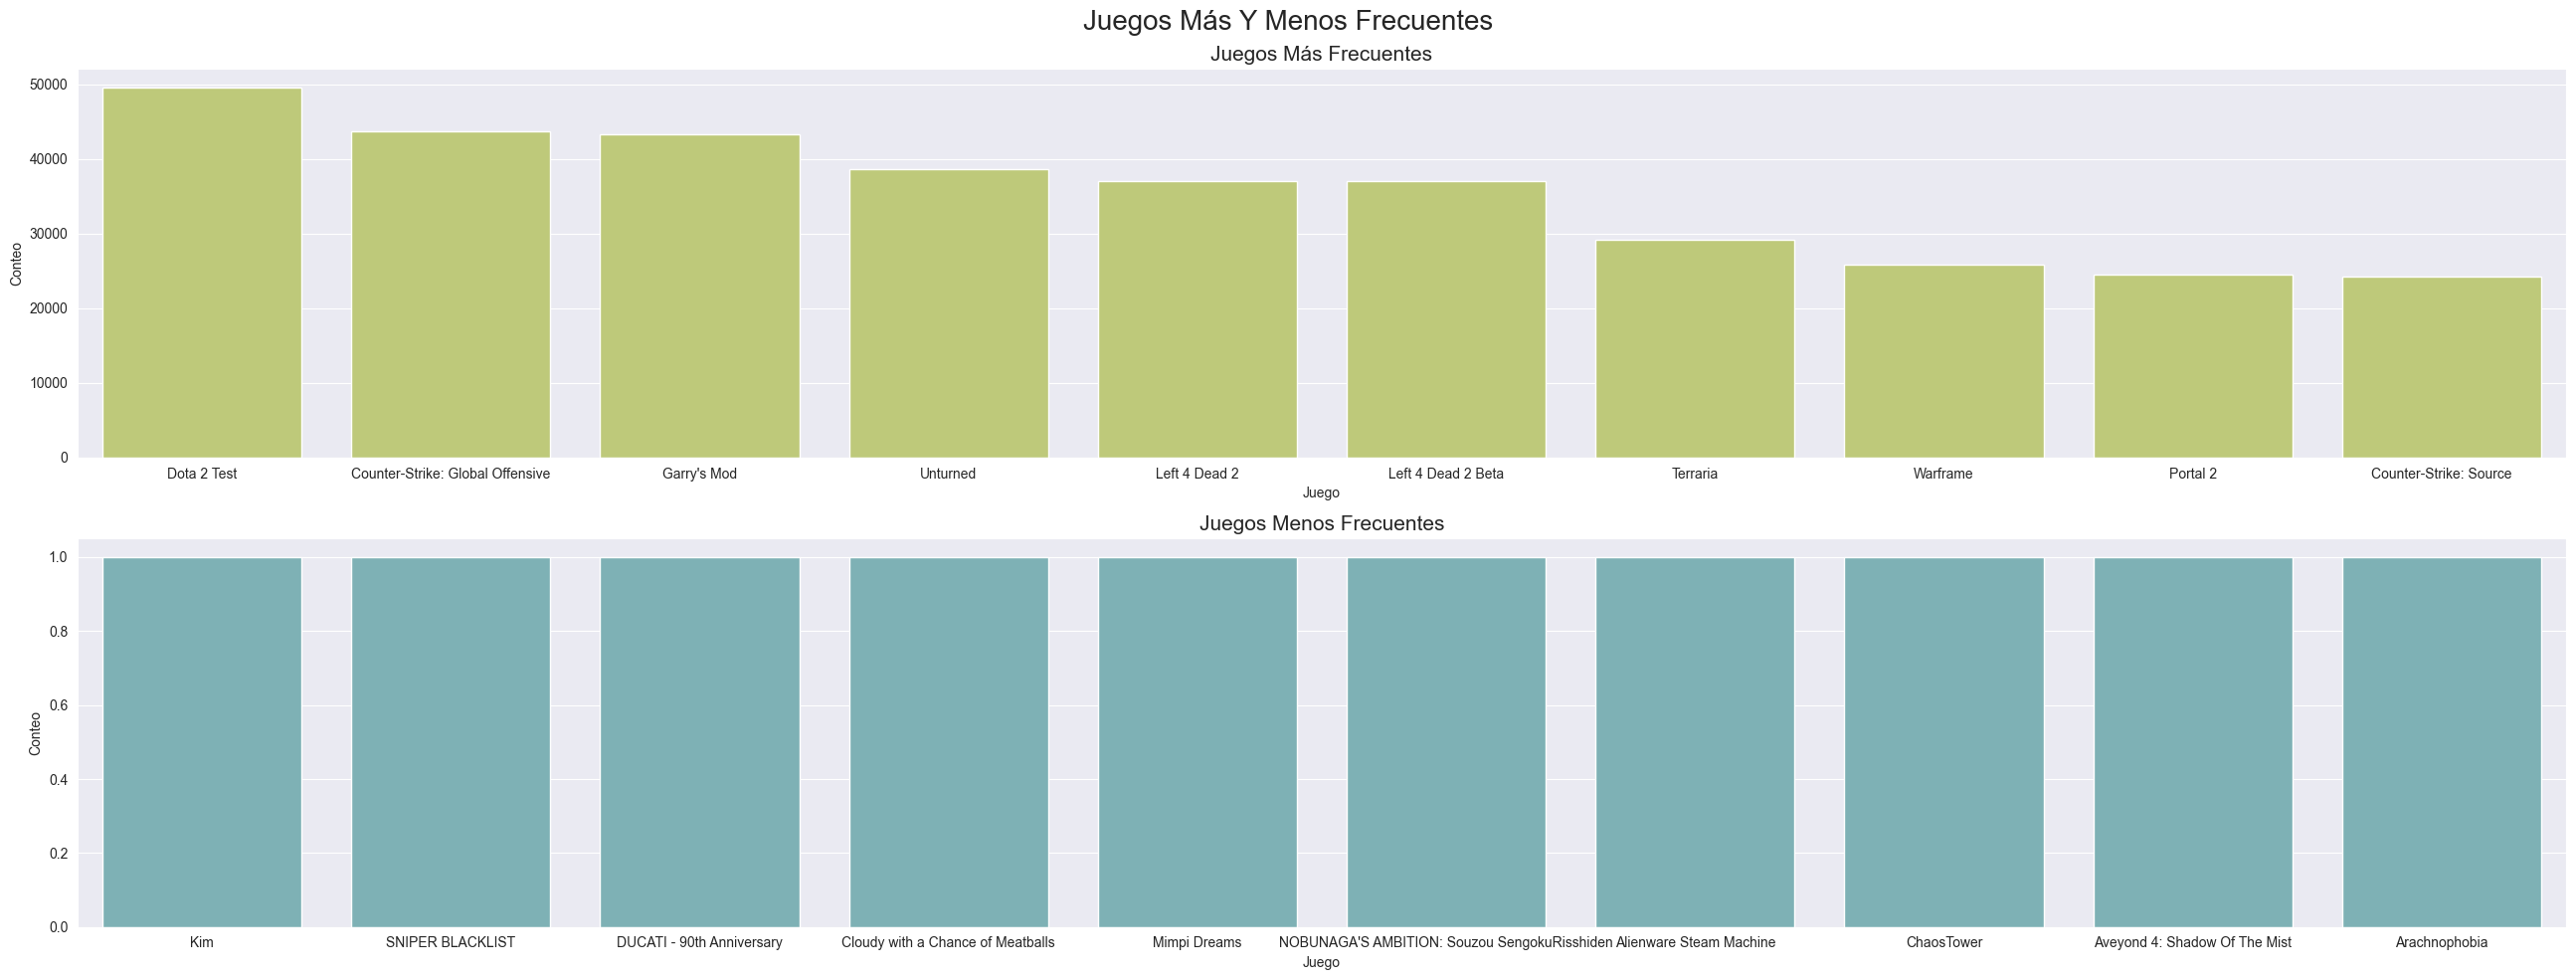

In [10]:
lis = []

for i in user_items['item_name']:
    lis.extend(i)

item_name = dict(sorted(dict(Counter(lis)).items(), key=lambda i:i[1], reverse=True))

fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(26)
fig.suptitle("Juegos Más Y Menos Frecuentes", fontsize=20)

sns.barplot(x=list(item_name.keys())[:10], y=list(item_name.values())[:10], ax=ax1, color="#C7D66D")
ax1.set_title("Juegos Más Frecuentes", fontsize=15)
ax1.set_xlabel("Juego")
ax1.set_ylabel("Conteo")

sns.barplot(x=list(item_name.keys())[-10:], y=list(item_name.values())[-10:], ax=ax2, color="#75B9BE")
ax2.set_title("Juegos Menos Frecuentes", fontsize=15)
ax2.set_ylabel("Conteo")
ax2.set_xlabel("Juego")

plt.tight_layout()
plt.show()

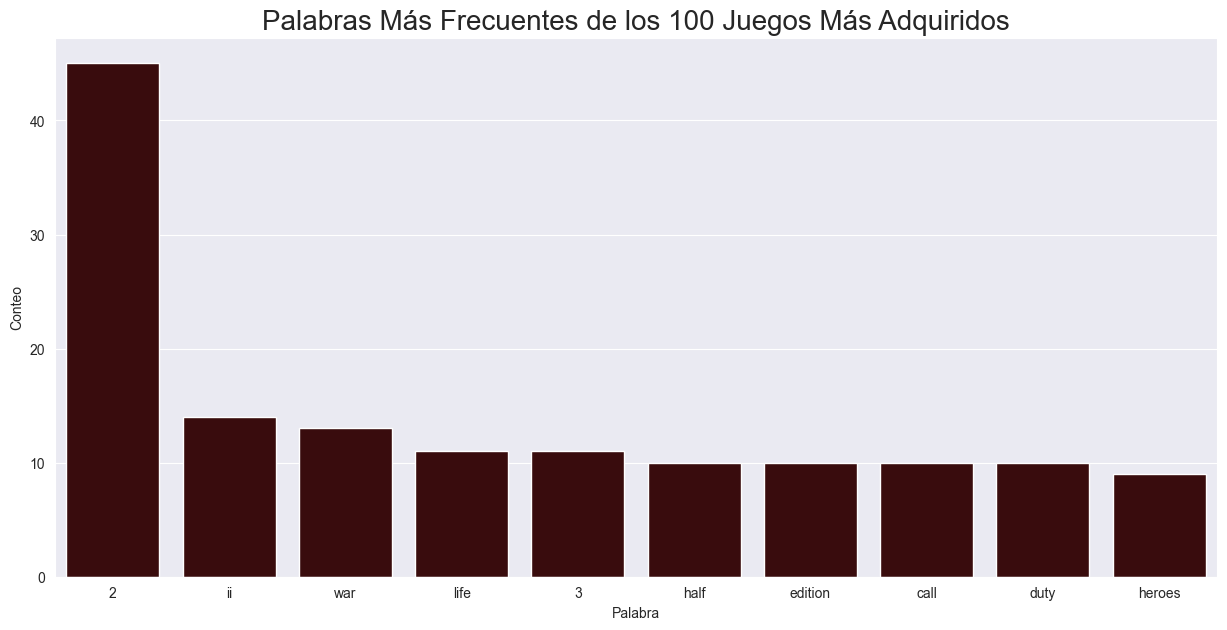

In [12]:
data = list(item_name.keys())[:300]

def TokenizeWord(s:str)->list:
    stop = stopwords.words("english")
    stop.extend([':','-',"'s"])

    l = nltk.tokenize.word_tokenize(re.sub("[^a-z0-9]+"," ", s.lower()))

    ans = [i for i in l if i not in stop]

    return ans

lis = []

for i in data:
    lis.extend(TokenizeWord(i))

top100names = dict(sorted(dict(Counter(lis)).items(), key=lambda i:i[1], reverse=True))

plt.figure(figsize=(15,7))

sns.barplot(x=list(top100names.keys())[:10], y=list(top100names.values())[:10], color="#400406")

plt.title("Palabras Más Frecuentes de los 100 Juegos Más Adquiridos", fontsize=20)
plt.ylabel("Conteo")
plt.xlabel("Palabra")
plt.show()